# Mask ocean from tiles

In [1]:
# import geopandas as gpd
# import pandas as pd
# import pathlib
# import pystac

import numpy as np
import rasterio
from rasterio.features import shapes, geometry_mask
import rioxarray
import json
import os


In [2]:
import os
os.getcwd()

'/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/github/AutomatedDamageDetection/notebooks/preprocessing'

### Get tile and normalise

In [3]:
homedir = '/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/'
catalog_path = os.path.join(homedir,'Data/tiles')

dataPath = os.path.join(homedir,'Data/tiles/training_tiles')
imName = 'S2_composite_2019-11-1_2020-3-1_tile_50.tif'

data = rioxarray.open_rasterio(os.path.join(dataPath,imName) ).isel(band=[0,1,2])
data.rio.bounds()

print(data.min().values, data.max().values)



1 19712


In [4]:
data.shape
# data.transpose('y','x','band').plot.imshow(vmin=0,vmax=10000)  # samples, x_win, y_win, bands

(3, 12503, 12505)

## Get ocean mask and apply

<AxesSubplot:>

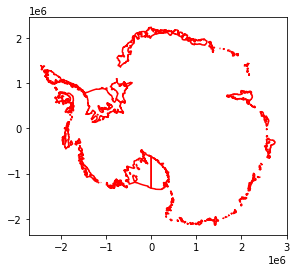

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt

iceshelf_poly_path = os.path.join(homedir,'Data/ne_10m_antarctic_ice_shelves_polys/ne_10m_antarctic_ice_shelves_polys.shp')
iceshelf_poly = gpd.read_file(iceshelf_poly_path).to_crs(epsg=3031)
# print(iceshelf_poly)
# iceshelf_poly.plot()

fig,ax=plt.subplots(1)
iceshelf_poly.to_crs(epsg=3031).boundary.plot(ax=ax,color='red')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


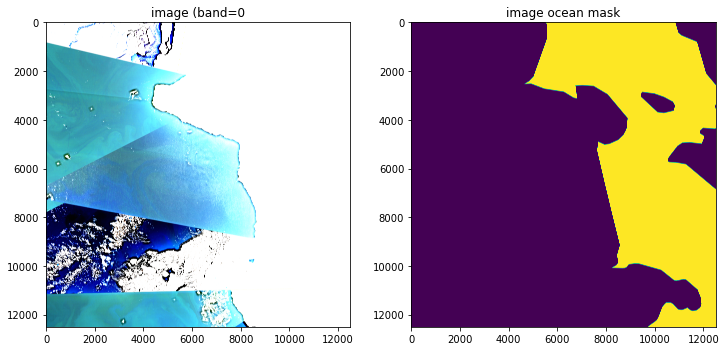

In [67]:
gdf = iceshelf_poly
mask = data.copy(data=np.ones_like(data.values)) # set up img with only 1 vluess
mask = mask.rio.clip(gdf.geometry, gdf.crs, drop=False, invert=False) # mask 

fig,axs = plt.subplots(1,2,figsize=(12,6))
# axs[0].imshow(data.isel(band=0)) 
axs[0].imshow(data.transpose('y','x','band'), vmin=0.4, vmax=1)
axs[1].imshow(mask.isel(band=0))
axs[0].set_title('image (band=0');
axs[1].set_title('image ocean mask');

## Demo: cut into windows, drop ocean windows, and stitch back together

In [40]:
def _generate_cutouts(da,xwin=100,ywin=100,stride=100):
    
    # generate windows
    da = da.rolling(x=xwin, y=ywin)
    da = da.construct({'x': 'x_win', 'y': 'y_win'}, stride=stride)

    # drop NaN-containing windows
    da = da.stack(sample=('x', 'y'))
    da = da.dropna(dim='sample', how='any') # (band, x_win, y_win, sample)

    return da.transpose('sample','y_win','x_win','band')

def encode_to_fake_lspace(windows):
    lspace = windows.mean(dim=['y_win','x_win'])
    return lspace

def unstack_data(encoded_data):
    output = encoded_data.unstack()  # x, y, bands 
    
    return output


### Example: without ocean mask

In [63]:
cutouts_data = _generate_cutouts(data)
print('cutouts shape ', cutouts_data.dims, cutouts_data.shape ) # n_samples, xwin, ywin, 3


encoded_da = encode_to_fake_lspace( cutouts_data    )
print('encoded data shape ' , encoded_da.dims, encoded_da.shape ) # samples, bands

decoded_da = unstack_data(encoded_da).transpose('band','y','x') # band, y , x
print('decoded data shape ' , decoded_da.dims, decoded_da.shape) # bands, x,y

# decoded_da.isel(band=0).plot.imshow()

cutouts shape  ('sample', 'y_win', 'x_win', 'band') (15625, 100, 100, 3)
encoded data shape  ('sample', 'band') (15625, 3)
decoded data shape  ('band', 'y', 'x') (3, 125, 125)


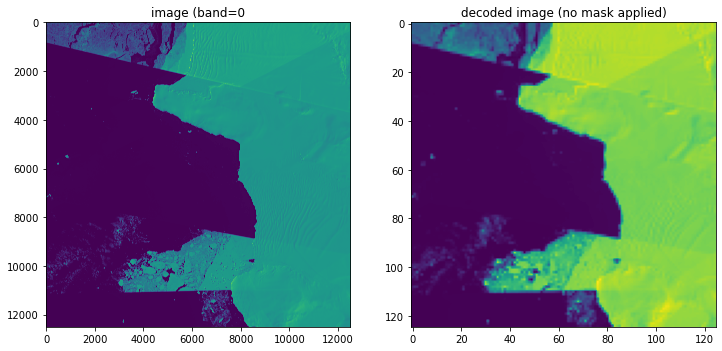

In [57]:
## With masking ocean pixels

data_masked = data.where(mask==1) # fill ocean pixels with NaN

cutouts_masked = _generate_cutouts(data_masked)
print('cutouts shape ', cutouts_data.dims, cutouts_data.shape ) # n_samples, xwin, ywin, 3

encoded_masked = encode_to_fake_lspace( cutouts_masked    )
print('encoded data shape ' , encoded_masked.dims, encoded_masked.shape ) # samples, bands

decoded_masked = unstack_data(encoded_masked).transpose('band','y','x') # band, y , x
print('decoded data shape ' , decoded_masked.dims, decoded_masked.shape) # bands, x,y


cutouts shape  ('sample', 'y_win', 'x_win', 'band') (15625, 100, 100, 3)


encoded data shape  ('sample', 'band') (4720, 3)
decoded data shape  ('band', 'y', 'x') (3, 125, 76)


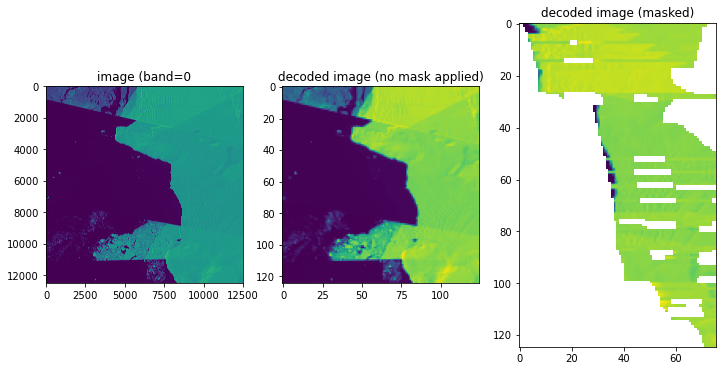

In [64]:
fig,axs = plt.subplots(1,3,figsize=(12,6))
axs[0].imshow(data.isel(band=0)) #.transpose('y','x','band'))
axs[1].imshow(decoded_da.isel(band=0))
axs[2].imshow(decoded_masked.isel(band=0))
axs[0].set_title('image (band=0');
axs[1].set_title('decoded image (no mask applied)');
axs[2].set_title('decoded image (masked)');